# MultiSensor Data Collection - Data visualization
Data viewer for information collected through the MultiSensor Data Collection Application, which is a mobile app that gathers data from various mobile sensors such as the accelerometer, gyroscope, magnetometer, and gravity. Data related to geolocation (GPS), audio, and video (camera) are also collected. All this information enables us to create a dataset related to **Human Activity Recognition** and **Urban Informatics**.

The goal of this notebook is to load a few sample datasets and present interesting visualizations.

## 1. Configuration
This section provides instructions for configuring the data path, defining file columns, loading essential libraries, and setting up Google Drive if required.

In [1]:
# Default python libraries
import csv
import datetime
import json
import os
import subprocess

# Third-party libraries
from IPython.display import Audio, HTML, Image
from matplotlib import animation
from moviepy.editor import CompositeVideoClip, VideoFileClip

import base64
import cv2
import imageio
import librosa
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Where are the files located?
PATH_DATA = 'MyDrive/science/creativision/projects/uic - vision and sensors/data/v5'
PATH_AVAILABLE_LABELS = 'MyDrive/science/creativision/projects/uic - vision and sensors/codes/taxonomy.csv'

GENERATE_COMPOSITE_VIDEOS = False

# Are they stored in Google Drive?
USE_GOOGLE_DRIVE = True

if USE_GOOGLE_DRIVE:
  from google.colab import drive

  PATH_GOOGLE_DRIVE = '/gdrive'
  drive.mount(PATH_GOOGLE_DRIVE)

  PATH_DATA = os.path.join('/gdrive', PATH_DATA)
  PATH_AVAILABLE_LABELS = os.path.join('/gdrive', PATH_AVAILABLE_LABELS)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## 2. Methods definition
This section contains:

- Definition of methods for data processing.
- Definition of methods for dataset assembling.
- Definition of methods for media visualization.
- Definition of methods for media plotting.
- Definition of methods for sensor and audio plotting.
- Definition of methods for multimodal visualization.

### 2.1. Methods for data processing

In [3]:
############
# utils.py #
############

def load_csv_data(path: str, fieldnames: list):
  '''
  Reads a CSV file using csv.DictReader and a predefined list of fields.
  '''
  data = []

  with open(path) as fin:
      for row in csv.DictReader(fin, fieldnames=fieldnames, delimiter=','):
          data.append(row)

  return data

def standardize_sensor_name(sensor_name):
  '''
  Obtains an adequately sensor's name
  '''
  sensor_name_lowered = sensor_name.lower()

  if 'accel' in sensor_name_lowered:
    if 'linear' in sensor_name_lowered:
      return 'Linear Accelerometer (m/s^2)'
    else:
      return 'Accelerometer (m/s^2)'

  if 'grav' in sensor_name_lowered:
    return 'Gravity (m/s^2)'

  if 'gyro' in sensor_name_lowered:
    return 'Gyroscope (rad/s)'

  if 'magn' in sensor_name_lowered:
    return 'Magnetometer (uT)'

  if 'light' in sensor_name_lowered:
    return 'Light (Lux)'

  if 'proximity' in sensor_name_lowered:
    if 'non' in sensor_name_lowered:
      return 'Proximity Non-Wakeup'
    return 'Proximity'

  return sensor_name

def generate_video_path(instance, sensor_name, composite=False):
  '''
  Generates a path to represent some content.
  '''
  stdz_name = sensor_name.split('(')[0].strip().replace(' ', '_').lower()

  instance_path_generated = os.path.join(instance.root_dir, instance.key, 'generated')
  if not os.path.exists(instance_path_generated):
    os.mkdir(instance_path_generated)
  if composite:
    stdz_name = f'{stdz_name}.composite'
  return os.path.join(instance_path_generated, f'{stdz_name}.mp4')

def preprocess_sensors(data, start_time, stop_time, ignore_extras=True):
  '''
  Converts the sensor data into appropriate data types and assigns time positions.
  '''
  series = {}
  ignored_lines = 0

  for row in data:
    sensor_name = standardize_sensor_name(row['name'])

    if ignore_extras:
      if 'Proximity' in sensor_name or 'Light' in sensor_name:
        continue

    ts = datetime.datetime.strptime(row['datetime_utc'], DATETIME_UTC_FORMAT)
    if ts < start_time or ts > stop_time:
      ignored_lines += 1
      continue

    if sensor_name not in series:
      series[sensor_name] = []

    current_data = [
      ts,
      float(row['axis_x']),
      float(row['axis_y']),
      float(row['axis_z'])
    ]
    series[sensor_name].append(current_data)

  return series

def convert_to_df(data, create_time_column=True):
  '''
  Converts data into a Pandas.DataFrame and includes a column to represent the duration in seconds of the time series
  '''
  df = pd.DataFrame(data, columns=['Datetime UTC', 'x', 'y', 'z'])

  if create_time_column:
      df['Datetime UTC'] = pd.to_datetime(df['Datetime UTC'], format=DATETIME_UTC_FORMAT)
      df['Time (s)'] = (df['Datetime UTC'] - df['Datetime UTC'].iloc[0]).dt.total_seconds()

  return df

def resample_sensor_data(sensor_data, target_fps=30):
    '''
    Converts the sensor data to match the FPS rate of the video.
    This is necessary because the frequency of sensor data varies.
    At times, there are 100 points in a single second, while at other times, there are only 50 points.
    This variation is controlled by the Android device, and it is crucial to ensure synchronization between the video and sensor data.
    '''
    sensor_data_df = convert_to_df(sensor_data)
    resampled_data = pd.DataFrame()

    for second in range(int(sensor_data_df['Time (s)'].max()) + 1):
        interval_start = second
        interval_end = second + 1

        selected_lines = sensor_data_df[(sensor_data_df['Time (s)'] >= interval_start) & (sensor_data_df['Time (s)'] < interval_end)]

        indices = [int(x) for x in np.linspace(
            start=0,
            stop=len(selected_lines) - 1,
            num=target_fps)
        ]

        sample = selected_lines.iloc[indices]
        resampled_data = pd.concat([resampled_data, sample])

    resampled_data.reset_index(drop=True, inplace=True)

    return resampled_data

def extract_audio(path: str, sample_rate=44100, channels=2, codec='pcm_s16le'):
  '''
  Extracts audio in WAV format from a video file
  '''
  source_dir = os.path.dirname(path)
  target_dir = os.path.join(source_dir, 'generated')
  if not os.path.exists(target_dir):
    os.mkdir(target_dir)

  mp4_name = os.path.basename(path)
  wav_path = os.path.join(target_dir, mp4_name.replace('.mp4', '.wav'))
  if not os.path.exists(wav_path):
    print(f'Extracting WAV from {path}')
    subprocess.call(['ffmpeg', '-i', path, '-vn', '-acodec', codec, '-ar', f'{sample_rate}', '-ac', f'{channels}', wav_path])

  return wav_path

def extract_gif(path: str, target_width=300, target_fps=2):
  '''
  Extracts a tiny video in GIF format from a video file
  '''
  source_dir = os.path.dirname(path)
  target_dir = os.path.join(source_dir, 'generated')
  if not os.path.exists(target_dir):
    os.mkdir(target_dir)

  mp4_name = os.path.basename(path)
  gif_path = os.path.join(target_dir, mp4_name.replace('.mp4', '.gif'))

  if not os.path.exists(gif_path):
    print(f'Extracting GIF from {path}')

    cap = cv2.VideoCapture(path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    target_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) * (target_width / cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
    target_resolution = (target_width, target_height)

    gif_frames_list = []
    frame_positions = [i for i in range(0, total_frames, int(original_fps) * 4)]

    for i in frame_positions:
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()

      if ret:
        if frame.shape[2] == 3:
          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        resized_frame = cv2.resize(frame, target_resolution)
        gif_frames_list.append(resized_frame)
      else:
        break

    imageio.mimsave(gif_path, gif_frames_list, fps=target_fps, subrectangles=True)

    cap.release()

  return gif_path

### 2.2. Methods for dataset assembling

In [4]:
#################
# exceptions.py #
#################

class RootDirIsNotADirectoryError(Exception):
  ...

class RootDirDoesNotExistError(Exception):
  ...

class MetadataFileDoesNotExistError(Exception):
  ...

class InvalidMetadataFileError(Exception):
  ...


#############
# models.py #
#############

DATETIME_UTC_FORMAT ="%Y-%m-%dT%H:%M:%S.%fZ"
LABELS_FIELDNAMES = [
    'category',
    'tag',
]
GPS_FILE_FIELDNAMES = [
    'datetime_utc',
    'gps_interval',
    'accuracy',
    'latitude',
    'longitude',
]
ONE_AXIS_SENSORS_FILE_FIELDNAMES = [
    'timestamp_nano',
    'datetime_utc',
    'name',
    'axis_x',
    'accuracy',
]
THREE_AXES_SENSORS_FILE_FIELDNAMES = [
    'timestamp_nano',
    'datetime_utc',
    'name',
    'axis_x',
    'axis_y',
    'axis_z',
    'accuracy',
]
THREE_AXES_UNCALIBRATED_SENSORS_FILE_FIELDNAMES = [
    'timestamp_nano',
    'datetime_utc',
    'name',
    'axis_x',
    'axis_y',
    'axis_z',
    'delta_x',
    'delta_y',
    'delta_z',
    'accuracy',
]
CONSUMPTION_FIELDNAMES = [
    'datetime_utc',
    'battery_microamperes',
]

class MSDataset:
  def __init__(self, root_dir, load_instances=True):
    if not os.path.isdir(root_dir):
      raise RootDirIsNotADirectoryError()

    if not os.path.exists(root_dir):
      raise RootDirDoesNotExistError()

    self.root_dir = root_dir if root_dir.endswith(os.path.sep) else f'{root_dir}{os.path.sep}'
    self.instances = {}
    self.setup()

    if load_instances:
      for k, v in self.instances.items():
        v.load()

  def setup(self):
    for current_dir, subdirs, files in os.walk(self.root_dir):
      for f in files:
        msf = MSFile(self.root_dir, os.path.join(current_dir, f))
        if msf.is_valid:
          if msf.instance_key() not in self.instances:
            self.instances[msf.instance_key()] = MSInstance(
              msf.city,
              msf.surface_type,
              msf.place_id,
              msf.collection_id
            )
            self.instances[msf.instance_key()].root_dir = msf.root_dir
          msi = self.instances[msf.instance_key()]
          msi.add_msfile(msf)

  def size(self):
    return len(self.instances)

  def iterator(self):
    for k in sorted(self.instances.keys()):
      yield self.instances[k]


class MSFile:
  def __init__(self, root_dir, path):
    self.root_dir = root_dir
    self.file_path = path
    self.discover()

  def discover(self):
    self.file_name = os.path.basename(self.file_path)
    self.is_valid = self.detect_file_type()
    if self.is_valid:
      self.detect_ids()
      self.detect_sensor_video()

  def detect_sensor_video(self):
    if self.file_type == 'video':
      self.is_composite = True if self.file_name.endswith('composite.mp4') else False
      self.is_sensor = True if (not self.file_name.endswith('video.mp4') and not self.is_composite) else False
      if self.is_composite or self.is_sensor:
        self.sensor_type = self.file_name.split('.')[0]
      else:
        self.sensor_type = ''

  def detect_ids(self):
    _abs_dirname = os.path.dirname(self.file_path)
    _rel_dirname = _abs_dirname.replace(self.root_dir, '')
    _ids = _rel_dirname.split(os.path.sep)

    if len(_ids) == 4:
      self.city, self.surface_type, self.place_id, self.collection_id = _ids
    elif len(_ids) == 5:
      self.city, self.surface_type, self.place_id, self.collection_id, _ = _ids

  def detect_file_type(self):
    if self.file_name.endswith('metadata.json'):
      self.file_type = 'metadata'
    elif self.file_name.endswith('labels.txt'):
      self.file_type = 'labels'
    elif self.file_name.endswith('consumption.csv'):
      self.file_type = 'consumption'
    elif self.file_name.endswith('gps.csv'):
      self.file_type = 'gps'
    elif self.file_name.endswith('sensors.three.csv'):
      self.file_type = 'sensors.three'
    elif self.file_name.endswith('sensors.three.uncalibrated.csv'):
      self.file_type = 'sensors.three.uncalibrated'
    elif self.file_name.endswith('sensors.one.uncalibrated.csv'):
      self.file_type = 'sensors.one.uncalibrated'
    elif self.file_name.endswith('sensors.one.csv'):
      self.file_type = 'sensors.one'
    elif self.file_name.endswith('.mp4'):
      self.file_type = 'video'
    elif self.file_name.endswith('video.wav'):
      self.file_type = 'audio'
    elif self.file_name.endswith('video.gif'):
      self.file_type = 'gif'
    else:
      self.file_type = 'unknown'
      print(f'WARNING,Unknown file type detected,{self.file_path}')
      return False
    if self.file_type != 'unknown':
      return True

  def instance_key(self):
    return os.path.sep.join([self.city, self.surface_type, self.place_id, self.collection_id])

  def __str__(self):
    return f'{self.file_name}'

  def __repr__(self):
    return self.__str__()


class MSInstance:
  def __init__(self, city, surface_type, place_id, collection_id):
    self.city = city
    self.surface_type = surface_type
    self.place_id = place_id
    self.collection_id = collection_id
    self.files = {'videos': {},}
    self.key = os.path.sep.join([
      self.city,
      self.surface_type,
      self.place_id,
      self.collection_id
    ])

  def add_msfile(self, msfile):
    if msfile.file_type == 'video':
      if msfile.is_composite:
        self.files['videos'][f'{msfile.sensor_type}.composite'] = msfile
      elif msfile.is_sensor:
        self.files['videos'][msfile.sensor_type] = msfile
      else:
        self.files['videos']['original'] = msfile
    else:
      self.files[msfile.file_type] = msfile

  def __str__(self):
    _str_files = '\n\t'.join([f.file_path for f in self.files.values()])
    return f'-----\nID\t{self.key}\nFiles\t{_str_files}'

  def __repr__(self):
    return self.__str__()

  def print_metadata(self):
    print(
      f"ID: {self.key}",
      f"City: {self.city}",
      f"Surface Type: {self.surface_type}",
      f"Place Number: {self.place_id}",
      f"Collection Number: {self.collection_id}",
      f"Manufacturer: {self.metadata['device']['manufacturer'].title()}",
      f"Model: {self.metadata['device']['model']}",
      f"Android version: {self.metadata['device']['androidVersion']}",
      f"Category: {self.metadata['category']}",
      f"Start video time: {self.metadata['time']['videoStartDateTime']}",
      f"Stop video time: {self.metadata['time']['videoStopDateTime']}",
      f"Category: {self.metadata['category']}",
      f"Tags: {', '.join(self.metadata['tags'])}",
      f"Sensors: {', '.join(self.data.get('sensors_three', []))}",
      sep='\n'
    )

  def load(self):
    self.data = {'videos': {}}

    try:
      with open(self.files['metadata'].file_path) as json_file:
        self.metadata = json.load(json_file)
    except KeyError:
      raise MetadataFileDoesNotExistError()

    if self.metadata is None:
      raise InvalidMetadataFileError()

    self.data['start_time'] = datetime.datetime.strptime(
      self.metadata['time']['videoStartDateTime'],
      DATETIME_UTC_FORMAT
    )

    self.data['stop_time'] = datetime.datetime.strptime(
      self.metadata['time']['videoStopDateTime'],
      DATETIME_UTC_FORMAT
    )

    for k, v in self.files.items():
      if k == 'consumption':
        self.data['consumption'] = load_csv_data(v.file_path, fieldnames=CONSUMPTION_FIELDNAMES)

      if k == 'gps':
        self.data['gps'] = load_csv_data(v.file_path, fieldnames=GPS_FILE_FIELDNAMES)

      if k == 'sensors.three':
        self.data['sensors_three'] = preprocess_sensors(
          load_csv_data(
            v.file_path,
            fieldnames=THREE_AXES_SENSORS_FILE_FIELDNAMES
          ),
          self.data['start_time'],
          self.data['stop_time']
        )

      if k == 'sensors.three.uncalibrated':
        # ToDo
        ...

      if k == 'sensors.one.uncalibrated':
        # ToDo
        ...

      if k == 'labels':
        self.data['labels'] = load_csv_data(v.file_path, fieldnames=LABELS_FIELDNAMES)

      if k == 'video':
        self.data['videos']['original'] = v.file_path
        self.data['audio'] = extract_audio(v.file_path)
        self.data['gif'] = extract_gif(v.file_path)

### 2.3. Methods for media visualization

In [5]:
def play_video(path: str):
  '''
  Plays the video.
  '''
  mp4 = open(path,'rb').read()
  data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
  return HTML("""<video width=400 controls><source src="%s" type="video/mp4"></video>""" % data_url)

def play_gif(path: str):
  '''
  Displays the GIF.
  '''
  with open(path, 'rb') as f:
    display(Image(data=f.read(), format='png'))

def play_audio(path: str):
  '''
  Plays the audio track.
  '''
  return display(Audio(path))

### 2.4 Methods for media plotting

In [6]:
def plot_audio(path: str):
  '''
  Plots the waveform and the Mel spectrogram for the specified audio file.
  '''
  y, sr = librosa.load(path)
  M = librosa.feature.melspectrogram(y=y, sr=sr)
  M_db = librosa.power_to_db(M, ref=np.max)

  fig, ax = plt.subplots(nrows=2, sharex=True)
  librosa.display.waveshow(y, sr=sr, ax=ax[0])
  ax[0].set(title='Waveform')
  ax[0].label_outer()

  img1 = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax[1])
  ax[1].set(title='Mel spectrogram')
  fig.colorbar(img1, ax=ax[1], format="%+2.f dB", location='bottom')

def plot_video_frames(video_path: str):
    '''
    Plots a sample of frames for the specified video_path.
    '''
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_indices = [0] + [int(i * total_frames / 10) for i in range(1, 10)]

    rows = 2
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

    for i, idx in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        time_in_seconds = idx / fps

        ax = axes[i // cols, i % cols]
        ax.imshow(frame_rgb)
        ax.set_title(f'Frame {idx} - {time_in_seconds:.2f}')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    cap.release()

def plot_video_frames_at_times(video_path, times):
    '''
    Plots frames for the specified video path at the given time points.
    '''
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    num_frames = len(times)

    rows = 1
    cols = num_frames
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3))

    for i, time_in_seconds in enumerate(times):
        frame_idx = int(time_in_seconds * fps)

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        ret, frame = cap.read()

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        ax = axes[i]
        ax.imshow(frame_rgb)
        ax.set_title(f'{time_in_seconds:.2f}')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    cap.release()

### 2.5 Methods for sensor and audio plotting

In [7]:
def plot_sensors_and_audio(sensors_data, audio_path, main_title=''):
  '''
  Creates a plot for the sensors and audio data.
  It is useful for plotting data related with an instance/sample.
  '''
  number_of_sensor_subplots = len(sensors_data.keys())
  number_of_audio_subplots = 2
  total_subplots = number_of_sensor_subplots + number_of_audio_subplots

  fig, axis = plt.subplots(total_subplots, 2, figsize=(15, 15), width_ratios=[3, 1], sharex=False)
  fig.suptitle(main_title, fontsize=15)

  x_ti = 0
  x_tf = None

  for ind, sensor_name in enumerate(sorted(sensors_data.keys())):
    sensor_data = convert_to_df(sensors_data[sensor_name])

    if not x_tf:
      x_tf = sensor_data['Time (s)'].iloc[-1]

    axis[ind, 0].set_ylabel(sensor_name)

    axis[ind, 0].plot(sensor_data['Time (s)'], sensor_data['x'], label='x', linewidth=0.75)
    axis[ind, 0].plot(sensor_data['Time (s)'], sensor_data['y'], label='y', linewidth=0.75)
    axis[ind, 0].plot(sensor_data['Time (s)'], sensor_data['z'], label='z', linewidth=0.75)
    axis[ind, 0].set_xlabel('Time (s)')
    axis[ind, 0].set_xlim((x_ti, x_tf))

    axis[ind, 1].hist(sensor_data['x'], label='x', alpha=0.4)
    axis[ind, 1].hist(sensor_data['y'], label='y', alpha=0.4)
    axis[ind, 1].hist(sensor_data['z'], label='z', alpha=0.4)
    axis[ind, 1].set_ylabel('Frequency')

    axis[ind, 0].legend()
    axis[ind, 1].legend()

    if ind == number_of_sensor_subplots - 1:
      y, sr = librosa.load(audio_path)
      M = librosa.feature.melspectrogram(y=y, sr=sr)
      M_db = librosa.power_to_db(M, ref=np.max)

      librosa.display.waveshow(y, sr=sr, ax=axis[ind + 1, 0])
      axis[ind + 1, 0].set_xlim((x_ti, x_tf))
      axis[ind + 1, 0].set_ylabel('Waveform')
      axis[ind + 1, 0].set_xlabel('Time (s)')

      img = librosa.display.specshow(
          M_db,
          y_axis='mel',
          x_axis='time',
          ax=axis[ind + 2, 0]
      )
      axis[ind + 2, 0].set_ylabel('Mel spectrogram (Hz)')
      axis[ind + 2, 0].set_xlabel('Time (s)')
      fig.colorbar(
          img,
          ax=axis[ind + 2, 1],
          format="%+2.f dB",
          location='left'
      )

      axis[ind + 1, 1].axis('off')
      axis[ind + 2, 1].axis('off')

  plt.tight_layout()
  plt.show()

def plot_instances_for_sensor(sensor_name=None, initial_xlim=(0, 30), dataset:MSDataset=None, identifiers=[]):
  '''
  Creates a subplot composed of 1xn time series where n is the number of instances/samples. It is required to indicate the sensor's name.
  '''
  if len(identifiers) == 0:
    print('ERROR,Empty list of identifiers')
    return

  if len(identifiers) == 1:
    print('ERROR,The list of identifiers must contain two or more identifiers')
    return

  _content = []

  for i in identifiers:
    _instance = dataset.instances.get(i, None)
    if not _instance:
      print(f'WARNING,{i} does not exist')
      continue

    _content.append([
        _instance.key,
        _instance.data['sensors_three'].get(sensor_name, [])
    ])

  _, axis = plt.subplots(len(_content), 1, figsize=(15, int(len(_content) * 4)), sharex=True)

  for ind, _key_sensor in enumerate(_content):
    _key, _sensor = _key_sensor
    _data = convert_to_df(_sensor)

    axis[ind].plot(_data['Time (s)'], _data['x'], label='x', linewidth=0.75)
    axis[ind].plot(_data['Time (s)'], _data['y'], label='y', linewidth=0.75)
    axis[ind].plot(_data['Time (s)'], _data['z'], label='z', linewidth=0.75)
    axis[ind].set_title(_key)
    axis[ind].legend()
    axis[ind].set_xlim(initial_xlim)

  plt.tight_layout()
  plt.show()

### 2.6. Methods for multimodal visualization
This section introduces a few techniques that have enabled us to visualize a video along with sensor values, all within a single MP4 video. The goal is to streamline the process of identifying points of interest related to the sensors and to observe what actually transpired during the video recording.

In [8]:
def plot_sensor_data_for_video(sensor_data, use_resampled_data=True):
  '''
  Plots the sensor data to preview how the visualization will appear the final video.
  '''
  if use_resampled_data:
      data = resample_sensor_data(sensor_data)
  else:
      data = convert_to_df(sensor_data)

  plt.ion()

  mpl.rcParams['lines.linewidth'] = 1
  mpl.rcParams['font.family'] = 'monospace'

  fig, ax = plt.subplots(1, 1, figsize = (15, 3))

  ax.xaxis.set_visible(True)
  ax.yaxis.set_visible(True)
  ax.minorticks_on()
  ax.set_frame_on(False)
  fig.patch.set_alpha(0.0)

  time_min = np.min(data['Time (s)'])
  time_max = np.max(data['Time (s)'])
  axis_min = np.min(np.min(data[['x', 'y', 'z']]))
  axis_max = np.max(np.max(data[['x', 'y', 'z']]))
  axis_dt = int(abs((axis_max - axis_min)) * 0.1) or 1

  ax.plot(data['Time (s)'], data['x'], label='x')
  ax.plot(data['Time (s)'], data['y'], label='y')
  ax.plot(data['Time (s)'], data['z'], label='z')
  ax.legend(loc="upper center", ncols=3, frameon=True, labelcolor="linecolor", fontsize="large")

  ax.set_xlim([time_min, time_max])
  ax.set_ylim([axis_min - axis_dt, axis_max + axis_dt])
  ax.set_facecolor((1, 1, 1, 0))
  ax.set_frame_on(True)

  plt.show()

def generate_video_for_sensor(instance, sensor_name, use_resampled_data=True, use_dynamic_xaxis=False, overwrite_existant_video=False):
  '''
  Generates a video to represent the time series.
  '''
  sensor_data = instance.data['sensors_three'][sensor_name]
  target_path = generate_video_path(instance, sensor_name, False)
  if os.path.exists(target_path) and not overwrite_existant_video:
    return target_path

  print(f'Generating sensor video at {target_path} for {sensor_name} and ID {instance.key}')
  if use_resampled_data:
    data = resample_sensor_data(sensor_data)
  else:
    data = convert_to_df(sensor_data)

  plt.ion()

  mpl.rcParams['lines.linewidth'] = 2
  mpl.rcParams['font.family'] = "monospace"

  fig, ax = plt.subplots(1, 1, figsize = (15, 3))

  time_min = np.min(data['Time (s)'])
  time_max = np.max(data['Time (s)'])
  axis_min = np.min(np.min(data[['x', 'y', 'z']]))
  axis_max = np.max(np.max(data[['x', 'y', 'z']]))
  axis_dt = int(abs((axis_max - axis_min)) * 0.1) or 1

  fps = int(len(data['x'])/time_max)

  def animate(i):
    ax.cla()

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_facecolor((0, 0, 0, 0))
    ax.set_frame_on(False)
    fig.patch.set_alpha(0.0)

    if not use_dynamic_xaxis:
        ax.set_xlim([time_min, time_max])
    ax.set_ylim([axis_min - axis_dt, axis_max + axis_dt])

    ax.plot(data['Time (s)'][:i], data['x'][:i])
    ax.plot(data['Time (s)'][:i], data['y'][:i])
    ax.plot(data['Time (s)'][:i], data['z'][:i])

    ax.legend(["x", "y", "z"], loc="upper center", ncols=3, frameon=False, labelcolor="linecolor", fontsize="large")

  anim = animation.FuncAnimation(fig, animate, frames=len(data['x']), interval=200, blit=False, repeat=False)
  anim.save(
    target_path,
    codec='png',
    dpi=90,
    fps=fps,
    writer='ffmpeg',
    savefig_kwargs={
      "transparent": True,
      "facecolor": "none"}
  )

  return target_path

def generate_video_with_sensor(instance, sensor_name, use_dynamic_xaxis=True, use_resampled_data=True, overwrite_existant_video=False):
  sensor_data = instance.data['sensors_three'][sensor_name]
  sensor_video_path = generate_video_path(instance, sensor_name)

  if overwrite_existant_video or not os.path.exists(sensor_video_path):
    generate_video_for_sensor(
      instance,
      sensor_name,
      use_resampled_data=True,
      use_dynamic_xaxis=use_dynamic_xaxis,
      overwrite_existant_video=overwrite_existant_video
    )

  target_path = generate_video_path(instance, sensor_name, composite=True)
  if os.path.exists(target_path) and not overwrite_existant_video:
    return sensor_video_path, target_path

  print(f'Generating video at {target_path} for sensor {sensor_name} and ID {instance.key}')
  if use_resampled_data:
    sensor_data = resample_sensor_data(sensor_data)
  else:
    sensor_data = convert_to_df(sensor_data)

  vision_video = VideoFileClip(instance.files['videos']['original'].file_path)
  sensor_video = VideoFileClip(sensor_video_path, has_mask=True)

  composite_video = CompositeVideoClip(clips=[vision_video, sensor_video.set_position(('center', 'bottom'))])
  composite_video.write_videofile(filename=target_path, fps=30)

  vision_video.close()
  sensor_video.close()
  composite_video.close()

  return sensor_video_path, target_path

### 2.7. Methods for view dataset coverage

In [9]:
def available_labels(path):
  return [f.strip() for f in open(path)]

def plot_tags_coverage(dataset, all_labels):
  labels = {}
  for l in all_labels:
    labels[l.replace(' ', '_')] = 0

  for instance in dataset.iterator():
    for l in instance.data['labels']:
      cat, tag = l['category'], l['tag']
      k = f'{cat},{tag}'.replace(' ', '_')
      if k not in labels:
        labels[k] = 0
      labels[k] += 1

  df = pd.DataFrame.from_dict(data=labels, orient='index', columns=['Frequency'])
  df = df.fillna(0)
  df = df.astype(int)
  return df.style.applymap(func=lambda x: 'color: red' if x < 1 else 'color: black')

def plot_tags_coverage_by_surface_type(dataset, secondary_category='pavement condition'):
  surface_types = {}

  categories_and_tags = load_csv_data(PATH_AVAILABLE_LABELS, fieldnames=LABELS_FIELDNAMES)
  for ct in categories_and_tags:
    c = ct['category']
    t = ct['tag']

    if c == 'surface type':
      surface_types[t] = {}

  for st in surface_types:
    for ct in categories_and_tags:
      c = ct['category']
      t = ct['tag']

      if c == secondary_category:
        surface_types[st][t] = 0

  for instance in dataset.iterator():
    for l in instance.data['labels']:
      cat, tag = l['category'], l['tag']
      st = instance.surface_type.lower().replace('_', ' ')
      try:
        surface_types[st][tag] += 1
      except KeyError:
        ...

  df = pd.DataFrame(data=surface_types)
  df = df.fillna(0)
  df = df.astype(int)
  return df.style.applymap(func=lambda x: 'color: red' if x < 1 else 'color: black')

## 3. Viewing samples
This section provides instructions for reading and viewing samples.

In [10]:
# Loads the dataset
msd = MSDataset(PATH_DATA)

for i in msd.iterator():
  print(i.key)

Santos/Bluestone/Place_1/Collection_1
Santos/Bluestone/Place_1/Collection_2
Santos/Bluestone/Place_1/Collection_3
Santos/Concrete/Place_1/Collection_1
Santos/Concrete/Place_1/Collection_2
Santos/Concrete/Place_1/Collection_3
Santos/Concrete/Place_2/Collection_1
Santos/Concrete/Place_2/Collection_2
Santos/Concrete/Place_2/Collection_3
Santos/Concrete/Place_3/Collection_1
Santos/Concrete/Place_3/Collection_2
Santos/Concrete/Place_3/Collection_3
Santos/Concrete/Place_4/Collection_1
Santos/Concrete/Place_4/Collection_2
Santos/Concrete/Place_4/Collection_3
Santos/Concrete/Place_5/Collection_1
Santos/Concrete/Place_5/Collection_2
Santos/Concrete/Place_5/Collection_3
Santos/Stone_Pavement/Place_1/Collection_1
Santos/Stone_Pavement/Place_1/Collection_2
Santos/Stone_Pavement/Place_1/Collection_3
Santos/Stone_Pavement/Place_2/Collection_1
Santos/Stone_Pavement/Place_2/Collection_2
Santos/Stone_Pavement/Place_2/Collection_3
Santos/Tiles/Place_1/Collection_1
Santos/Tiles/Place_1/Collection_2
Santo

### 3.1. View one sample at a time

In [11]:
# Loads the indicated instance data into a dictionary with the keys sensors, gps, and media.
instance = msd.instances['Santos/Stone_Pavement/Place_2/Collection_1']

In [12]:
# Shows the instance metadata
instance.print_metadata()

ID: Santos/Stone_Pavement/Place_2/Collection_1
City: Santos
Surface Type: Stone_Pavement
Place Number: Place_2
Collection Number: Collection_1
Manufacturer: Samsung
Model: SM-G970F
Android version: 31
Category: Surface Type
Start video time: 2024-01-24T17:52:17.555Z
Stop video time: 2024-01-24T17:52:43.206Z
Category: Surface Type
Tags: 
Sensors: Accelerometer (m/s^2), Magnetometer (uT), Gyroscope (rad/s), Gravity (m/s^2), Linear Accelerometer (m/s^2)


In [13]:
# Shows the instance files
instance.files

{'videos': {'original': video.mp4,
  'accelerometer': accelerometer.mp4,
  'accelerometer.composite': accelerometer.composite.mp4,
  'gyroscope': gyroscope.mp4,
  'gyroscope.composite': gyroscope.composite.mp4},
 'sensors.three.uncalibrated': sensors.three.uncalibrated.csv,
 'gps': gps.csv,
 'sensors.three': sensors.three.csv,
 'sensors.one': sensors.one.csv,
 'metadata': metadata.json,
 'consumption': consumption.csv,
 'labels': labels.txt,
 'audio': video.wav,
 'gif': video.gif}

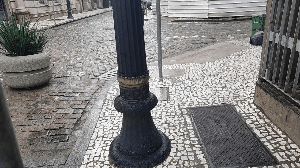

In [14]:
# Plays the gif associated with the video
play_gif(instance.files['gif'].file_path)

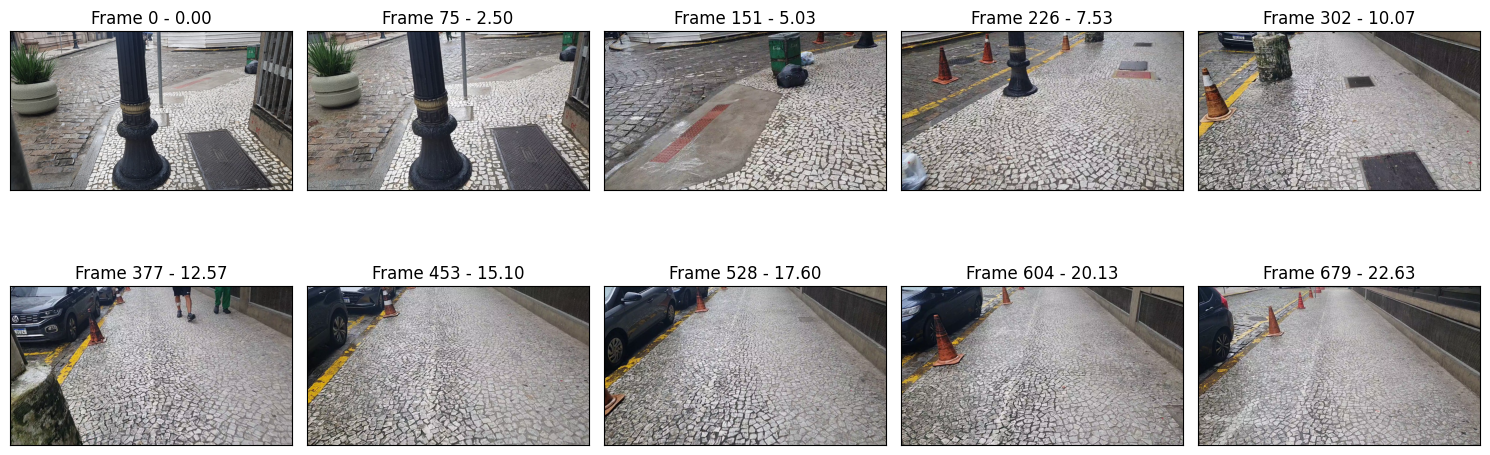

In [15]:
# Plots a few frames related with the video
plot_video_frames(instance.files['videos']['original'].file_path)

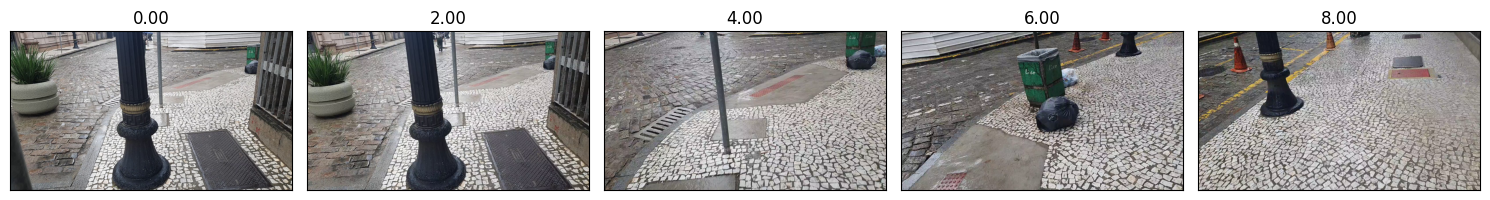

In [16]:
# Plots a few frames related with the video
plot_video_frames_at_times(instance.files['videos']['original'].file_path, range(0, 10, 2))

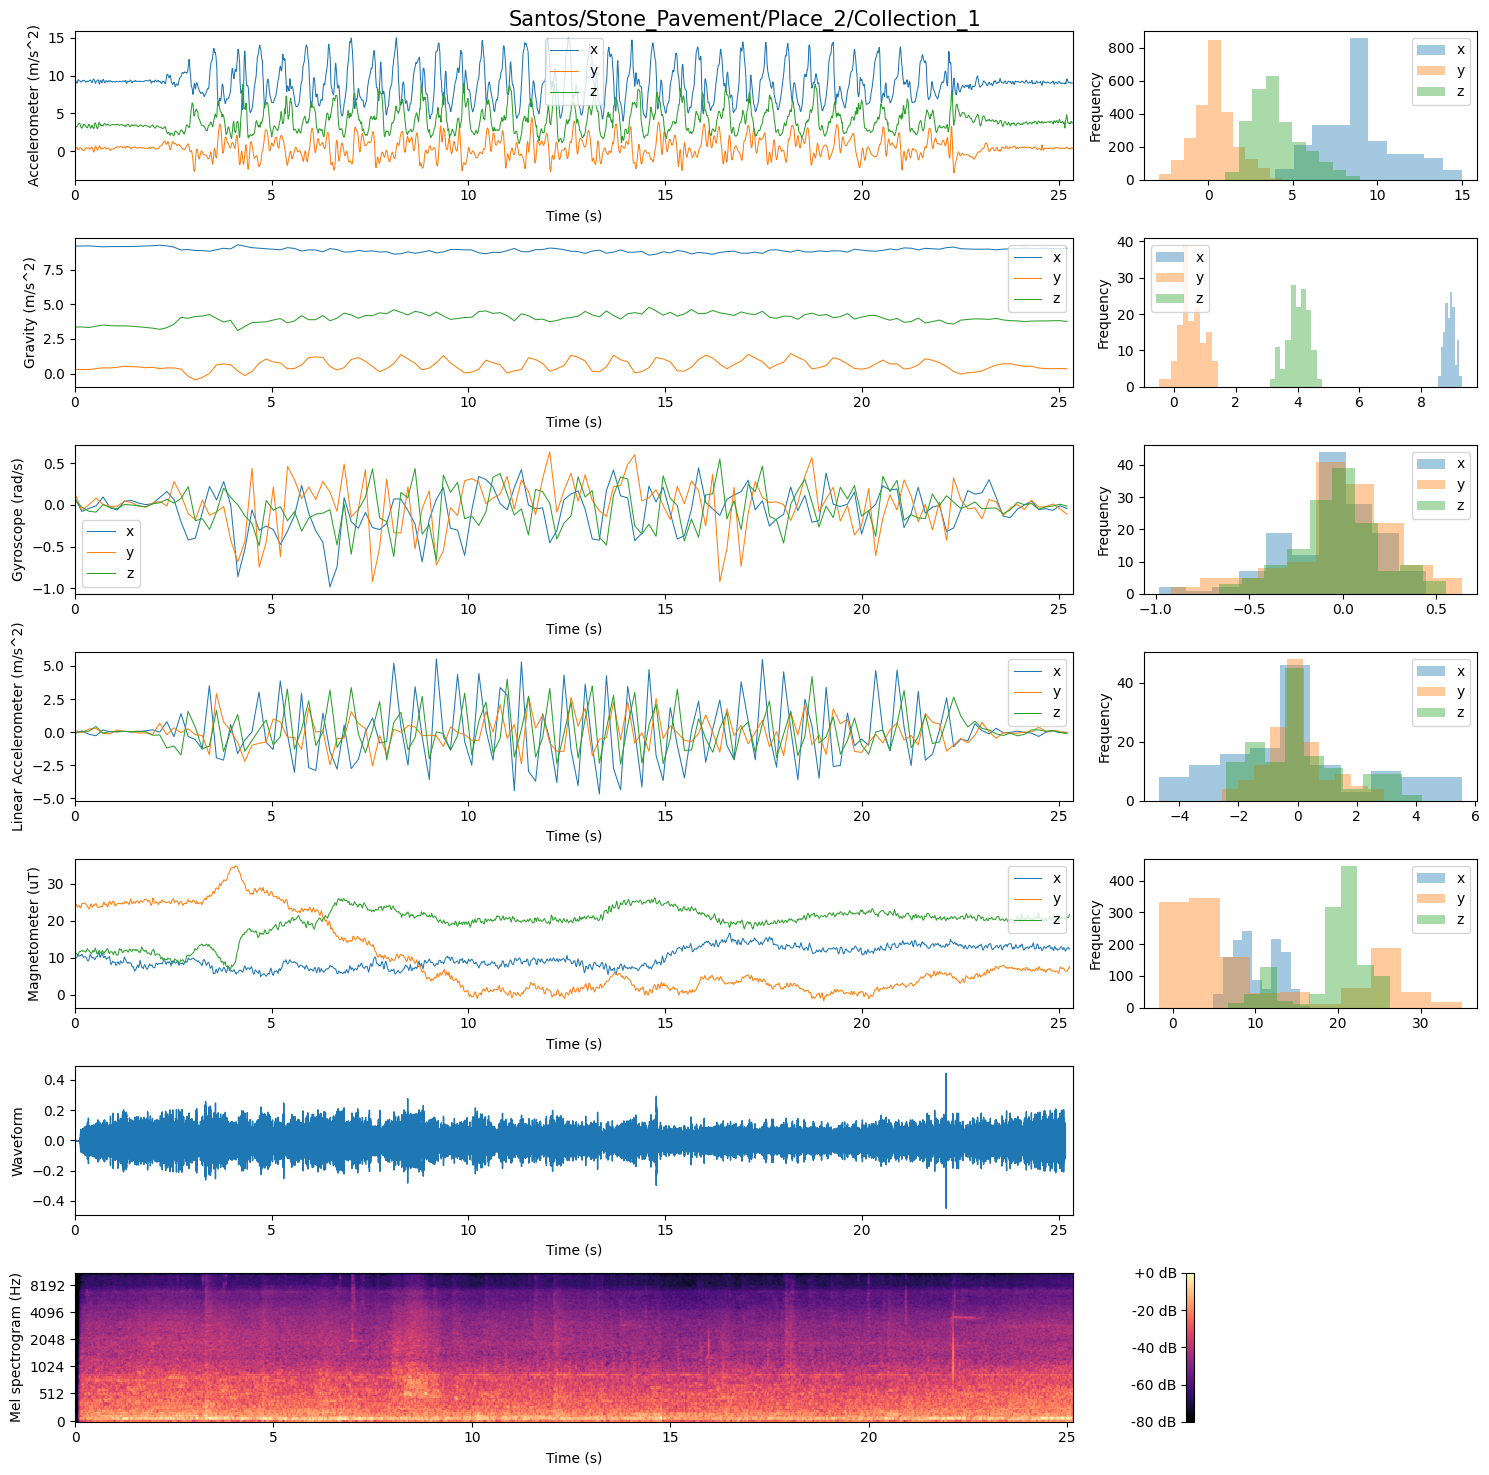

In [17]:
# Plots the time series and histograms of all sensors and the waveform and Mel spectogram of the audio data.
plot_sensors_and_audio(instance.data['sensors_three'], instance.files['audio'].file_path, instance.key)

### 3.2. View multiple samples/categories at a time
The idea is to present all instances (or the selected ones) associated with a single sensor at a time in an unified view.

In [18]:
identifiers = [
  'Santos/Bluestone/Place_1/Collection_1',
  'Santos/Concrete/Place_1/Collection_1',
  'Santos/Stone_Pavement/Place_1/Collection_1',
]

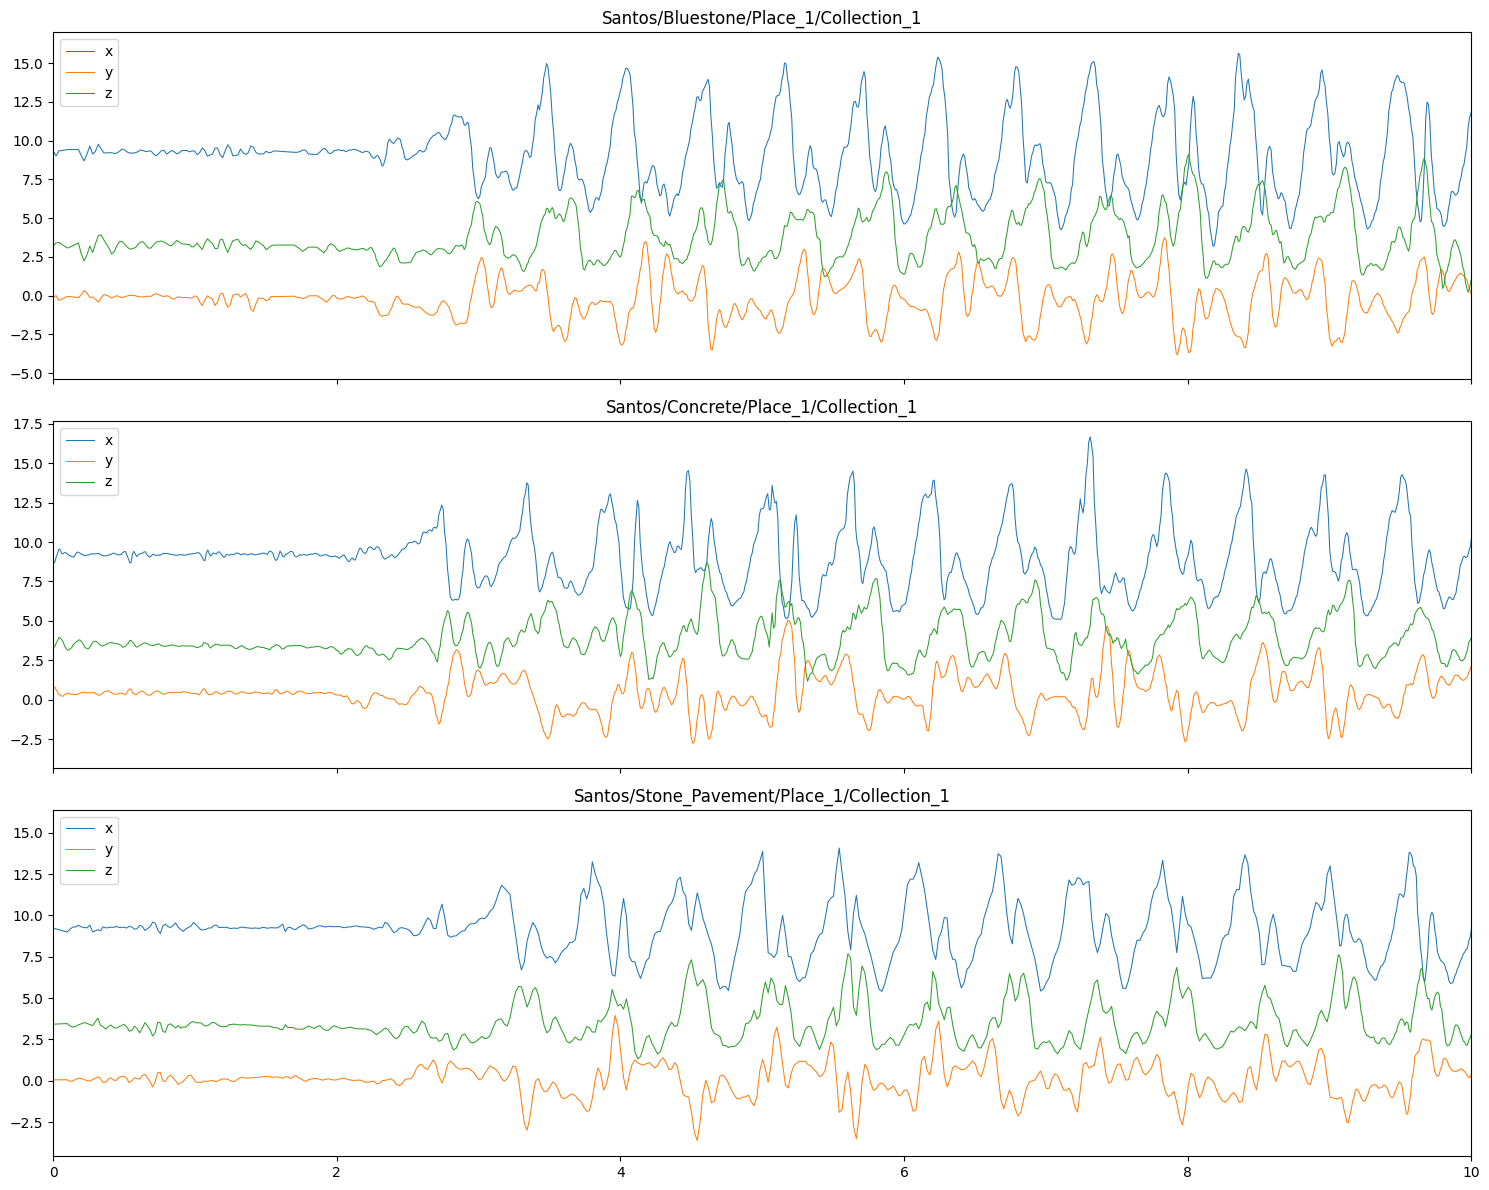

In [19]:
plot_instances_for_sensor(
    "Accelerometer (m/s^2)",
    initial_xlim=(0, 10),
    dataset=msd,
    identifiers=identifiers,
)

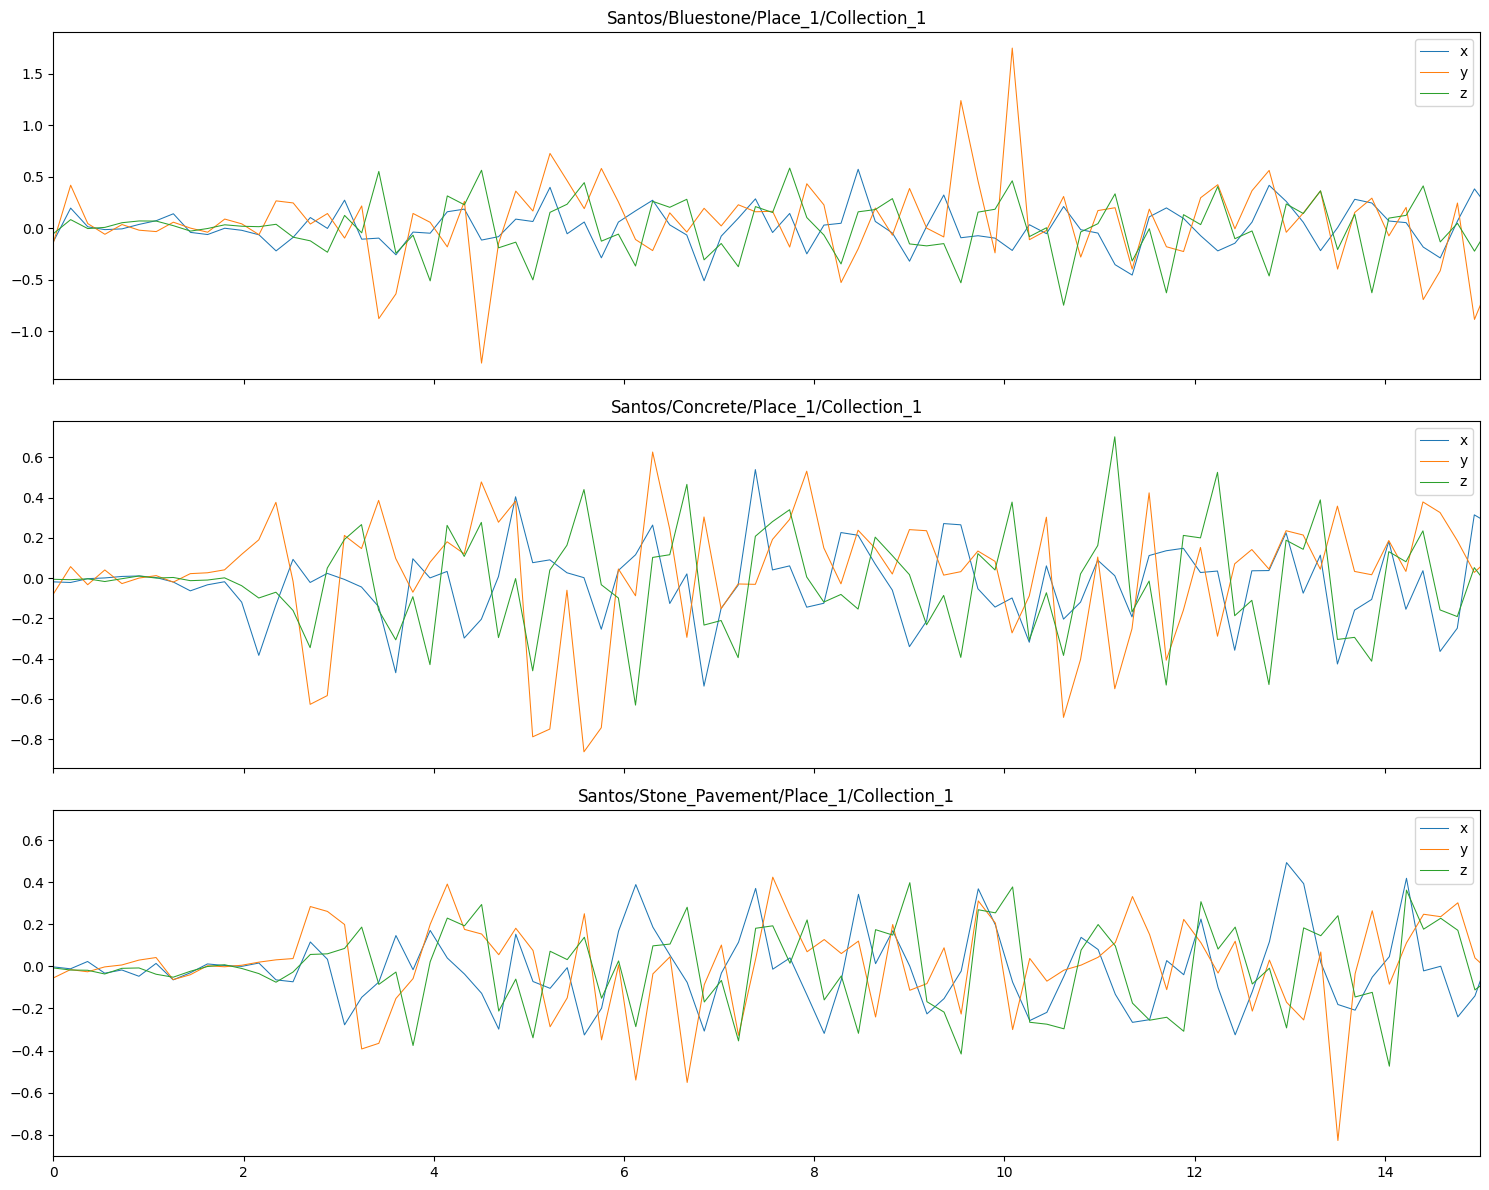

In [20]:
plot_instances_for_sensor(
    "Gyroscope (rad/s)",
    initial_xlim=(0, 15),
    dataset=msd,
    identifiers=identifiers,
)

### 3.3. View multimodal data
The concept is to showcase a video alongside its corresponding time series data from the sensors.

In [21]:
# Shows the sensors names
instance.print_metadata()

ID: Santos/Stone_Pavement/Place_2/Collection_1
City: Santos
Surface Type: Stone_Pavement
Place Number: Place_2
Collection Number: Collection_1
Manufacturer: Samsung
Model: SM-G970F
Android version: 31
Category: Surface Type
Start video time: 2024-01-24T17:52:17.555Z
Stop video time: 2024-01-24T17:52:43.206Z
Category: Surface Type
Tags: 
Sensors: Accelerometer (m/s^2), Magnetometer (uT), Gyroscope (rad/s), Gravity (m/s^2), Linear Accelerometer (m/s^2)


In [22]:
# Shows the instance's files
instance.files

{'videos': {'original': video.mp4,
  'accelerometer': accelerometer.mp4,
  'accelerometer.composite': accelerometer.composite.mp4,
  'gyroscope': gyroscope.mp4,
  'gyroscope.composite': gyroscope.composite.mp4},
 'sensors.three.uncalibrated': sensors.three.uncalibrated.csv,
 'gps': gps.csv,
 'sensors.three': sensors.three.csv,
 'sensors.one': sensors.one.csv,
 'metadata': metadata.json,
 'consumption': consumption.csv,
 'labels': labels.txt,
 'audio': video.wav,
 'gif': video.gif}

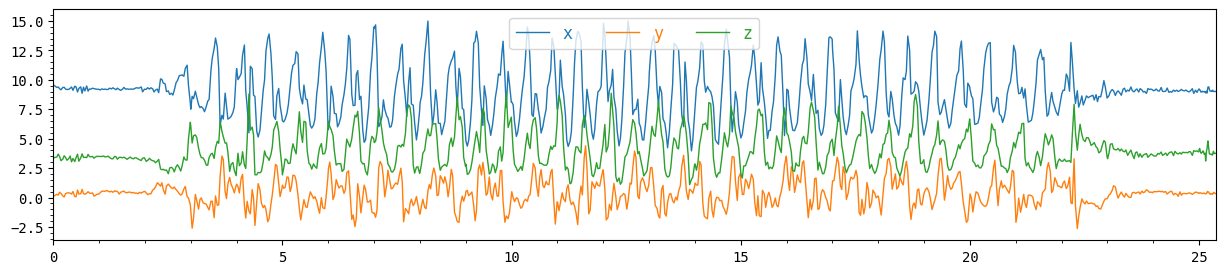

In [23]:
# Examining how the time series will appear in the final video
plot_sensor_data_for_video(
  instance.data['sensors_three']['Accelerometer (m/s^2)'],
  'Accelerometer (m/s^2)'
)

In [24]:
# Generating video for the sensor Gyroscope (rad/s)
_video_path = generate_video_for_sensor(
  instance=instance,
  sensor_name='Gyroscope (rad/s)',
  use_dynamic_xaxis=False,
  overwrite_existant_video=False
)

msf = MSFile(msd.root_dir, _video_path)
instance.add_msfile(msf)
instance.load()

In [25]:
# Generating the composite video (the original one combined with the sensor footage)
_sensor_video_path, composite_video_path = generate_video_with_sensor(
  instance=instance,
  sensor_name='Gyroscope (rad/s)',
  use_dynamic_xaxis=False,
  overwrite_existant_video=False
)

msf = MSFile(msd.root_dir, _sensor_video_path)
instance.add_msfile(msf)

msf = MSFile(msd.root_dir, composite_video_path)
instance.add_msfile(msf)

### 3.4. Batch generation of composite videos

In [26]:
if GENERATE_COMPOSITE_VIDEOS:
  for i in msd.iterator():
    _sensor_path, _composite_path = generate_video_with_sensor(
      instance=i,
      sensor_name='Accelerometer (m/s^2)',
      use_dynamic_xaxis=False,
      overwrite_existant_video=False
    )

    msf = MSFile(msd.root_dir, _sensor_path)
    i.add_msfile(msf)

    mdf = MSFile(msd.root_dir, _composite_path)
    i.add_msfile(msf)

    i.load()

In [27]:
if GENERATE_COMPOSITE_VIDEOS:
  for i in msd.iterator():
    _sensor_path, _composite_path = generate_video_with_sensor(
      instance=i,
      sensor_name='Gyroscope (rad/s)',
      use_dynamic_xaxis=False,
      overwrite_existant_video=False
    )

    msf = MSFile(msd.root_dir, _sensor_path)
    i.add_msfile(msf)

    mdf = MSFile(msd.root_dir, _composite_path)
    i.add_msfile(msf)

    i.load()

## 4. Viewing dataset coverage

In [37]:
all_labels = available_labels(PATH_AVAILABLE_LABELS)
_p = plot_tags_coverage(msd, all_labels)
_p.to_string('coverage.all.csv', delimiter=';')
_p

  return df.style.applymap(func=lambda x: 'color: red' if x < 1 else 'color: black')



In [38]:
_p = plot_tags_coverage_by_surface_type(msd, secondary_category='pavement condition')
_p.to_string('coverage.pavement_condition.csv', delimiter=';')
_p

  return df.style.applymap(func=lambda x: 'color: red' if x < 1 else 'color: black')



In [39]:
_p = plot_tags_coverage_by_surface_type(msd, secondary_category='adjacent road type')
_p.to_string('coverage.adjacent_road_type.csv', delimiter=';')
_p

  return df.style.applymap(func=lambda x: 'color: red' if x < 1 else 'color: black')



In [40]:
_p = plot_tags_coverage_by_surface_type(msd, secondary_category='sidewalk geometry')
_p.to_string('coverage.sidewalk_geometry.csv', delimiter=';')
_p

  return df.style.applymap(func=lambda x: 'color: red' if x < 1 else 'color: black')



In [41]:
_p = plot_tags_coverage_by_surface_type(msd, secondary_category='sidewalk structure')
_p.to_string('coverage.sidewalk_structure.csv', delimiter=';')
_p

  return df.style.applymap(func=lambda x: 'color: red' if x < 1 else 'color: black')



In [42]:
_p = plot_tags_coverage_by_surface_type(msd, secondary_category='obstacles')
_p.to_string('coverage.obstacles.csv', delimiter=';')
_p

  return df.style.applymap(func=lambda x: 'color: red' if x < 1 else 'color: black')



## 5. Methods for tagging multimodal data
In this section, we will introduce a few implementations for tagging a sample with respect to its video, audio and sensors data.

In [34]:
# ToDo

## 6. Methods for splitting videos
In this section, we will introduce ideas and preliminary tests related to methods for spliting video content based on sensor information. The objective is to utilize changes in the accelerometer, gyroscope, magnetometer and other sensor data to comprehensively divide a video into meaningful segments.

In [35]:
# ToDo

## 7. Methods for video stabilization
This section aims to develop and test methods to enhance the stability of videos recorded on mobile devices. One of the issues identified in the data collected through the MultiSensor Data Collection application was the lack of image stability over time, likely attributable to the natural movement of the device while the participant walked, ran, or engaged in other activities. The methods we will test involve leveraging sensors data to correct image stability.

In [36]:
# ToDo

# Semantic segmentation
Our goal is to create demonstration videos where the content is segmented into as many classes as possible. To achieve this, we plan to utilize segmentation models such as TMANet, finetuning them with a custom dataset if necessary. Our taxonomy could serve as a foundation for finetuning a model that is pre-trained on datasets like CityScapes. Here is the CityScapes available classes:

| Group         | Classes                                       |
|---------------|-----------------------------------------------|
| flat          | road · sidewalk · parking+ · rail track+      |
| human         | person* · rider*                              |
| vehicle       | car* · truck* · bus* · on rails* · motorcycle* · bicycle* · caravan*+ · trailer*+ |
| construction  | building · wall · fence · guard rail+ · bridge+ · tunnel+ |
| object        | pole · pole group+ · traffic sign · traffic light |
| nature        | vegetation · terrain                          |
| sky           | sky                                           |
| void          | ground+ · dynamic+ · static+                  |

And here is our current taxonomy:

| Category             | Tag                                             |
|----------------------|-------------------------------------------------|
| Adjacent road type   | Motorway/Highway · Residential · Service · None |
| Obstacles            | Aerial vegetation · Bench · Bike rack · Black ice · Bus stop · Car barrier · Construction material · Dirt · Fence · Fire hydrant · Garage entrance · Ground light · Ground vegetation · Manhole cover · Parked vehicle · Person · Pole · Potted plant · Puddle · Rock · Transit sign · Trash can · Tree leaves · Trunck · Water channel · Water fountain |
| Pavement condition   | Broken · Corrugation · Cracked · Detached · Patching · Pothole |
| Sidewalk geometry    | Height difference · Narrow · Steep |
| Sidewalk structure    | Bioswale · Curb ramp · Footbridge · Friction strip · Ramp · Stairs · Tactile paving |
| Surface type         | Asphalt · Bluestone · Brick · Coating · Concrete · Concrete with aggregates · Grass · Gravel · Large pavers · Red brick · Slab · Stone pavement · Tiles |
